In [1]:
year=2024

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
    bbox_to_dimensions,
)

# Notebook to extract information collected by Sentinel 2 - Layer L2A

## Get api keys from configuration file

In [3]:
config = SHConfig("cdse")

## Evalscript

In Sentinel Hub, the evalscript is a crucial component used to define custom processing scripts for satellite imagery. It allows users to specify how raw satellite data should be processed and transformed into meaningful information.

Collected bands:
- bande_1=B03,
- bande_2=B04,
- bande_3=B08,
- bande_4=dataMask,
- bande_5=isCloudVal,
- bande_6=ndwi -> computed,
- bande_7=ndvi -> computed,
- bande_8=isVegetal -> computed,
- bande_9=isWater -> computed,
- bande_10=(samples.dataMask === 1 ? ndwi : NaN) 

In [4]:
evalscript='''
//VERSION=3

function setup() {
  return {
    input: ["B03", "B04", "B08", "SCL", "dataMask"],
    output: [
      { id: "data", bands: 10, sampleType: "FLOAT32" } // Toutes les données dans une seule sortie
    ]
  };
}

function evaluatePixel(samples) {
  let ndwi = index(samples.B08, samples.B03);
  let ndvi = index(samples.B04, samples.B08);
  let isCloudVal = isCloud(samples.SCL) ? 1 : 0;
  let isVegetal = ndvi < 0 ? 1 : 0; // Nouveau flag pour ndvi
  let isWater = ndwi < 0 ? 1 : 0; // Nouveau flag pour vert/bleu

  return {
    data: [
      samples.B03,
      samples.B04,
      samples.B08,
      samples.dataMask,
      isCloudVal,
      ndwi,
      ndvi,
      isVegetal,
      isWater,
      (samples.dataMask === 1 ? ndwi : NaN) // Indice avec NaN pour les pixels masqués
    ]
  };
}

function isCloud(scl) {
  if (scl == 3) {
    // SC_CLOUD_SHADOW
    return false;
  } else if (scl == 9) {
    // SC_CLOUD_HIGH_PROBA
    return true;
  } else if (scl == 8) {
    // SC_CLOUD_MEDIUM_PROBA
    return true;
  } else if (scl == 7) {
    // SC_CLOUD_LOW_PROBA
    return false;
  } else if (scl == 10) {
    // SC_THIN_CIRRUS
    return true;
  } else if (scl == 11) {
    // SC_SNOW_ICE
    return false;
  } else if (scl == 1) {
    // SC_SATURATED_DEFECTIVE
    return false;
  } else if (scl == 2) {
    // SC_DARK_FEATURE_SHADOW
    return false;
  }
  return false;
}

'''

## BBOX

BBox we are interested in (covers NUTS 3 from North of Belgium and South of The Netherlands)

In [6]:
x1,y1,x2,y2=3919661,3107852,4053685,3201887
l=10000
x1=(x1//l)*l
y1=(y1//l)*l
x2=(x2//l)*l+l
y2=(y2//l)*l+l

print(f'BBOX: ({x1},{y1}))-({x2},{y2}) - # de carrés de 10km*10km = # de fichiers: {(x2-x1)/10000*(y2-y1)/10000}')

BBOX: (3910000,3100000))-(4060000,3210000) - # de carrés de 10km*10km = # de fichiers: 165.0


## Divide BBOX

Divide large BBOX in smaller BBOXes (10km*10km).

In [7]:
bboxes=[ [x,y,x+l,y+l] for x in range(x1,x2,l) for y in range(y1,y2,l) ]

## Get Tiff

Function to get info from Sentinel 2 for a given BBOX.

Important parameters passed to SentinelHub Request:
- time_interval=(  f'{year}-05-01' ,  f'{year}-06-30' ) for year in 201!, 2019, ..., 2024
- mosaicking_order='mostRecent',
- maxcc=0.1 --> maxcc = max cloud coverage
- resolution=10 --> Pixel size: 10m

In [8]:
def getTiff(bbox):
    
    nx,ny=bboxes[0:2]

    resolution = 10
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    
    print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")
    
    date_start=f'{year}-05-01'
    date_end=f'{year}-06-30'

    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                # Here we use the collection defined in the description further up
                DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                # The time interval for the data is a fixed date (see the description further up)
                time_interval=(date_start, date_end),
                mosaicking_order='mostRecent', # "mostRecent",
                maxcc=0.1
            )
        ],
        responses=[
            SentinelHubRequest.output_response("data", MimeType.TIFF)
        ],
        bbox=bbox,
        size=bbox_size,
        data_folder="data",
        config=config,
    )

    bands = request.get_data(save_data=True)

## Batch processing of BBOXes

In [9]:
%%time

for bbox in bboxes:
    bbox = BBox(bbox, crs=CRS(3035))
    getTiff(bbox)

Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (901, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution: (900, 1090) pixels
Image shape at 10 m resolution:

## Example of Tiff

Example of Tiff:
- Layer represented here: NDVI
- Filename: 013356689bd3389f3f29430412edb6a9_2018.tiff
- BBox: (4050000,3110000),(4060000,3120000) expressed in EPSG:3035
- There are 165 of such files

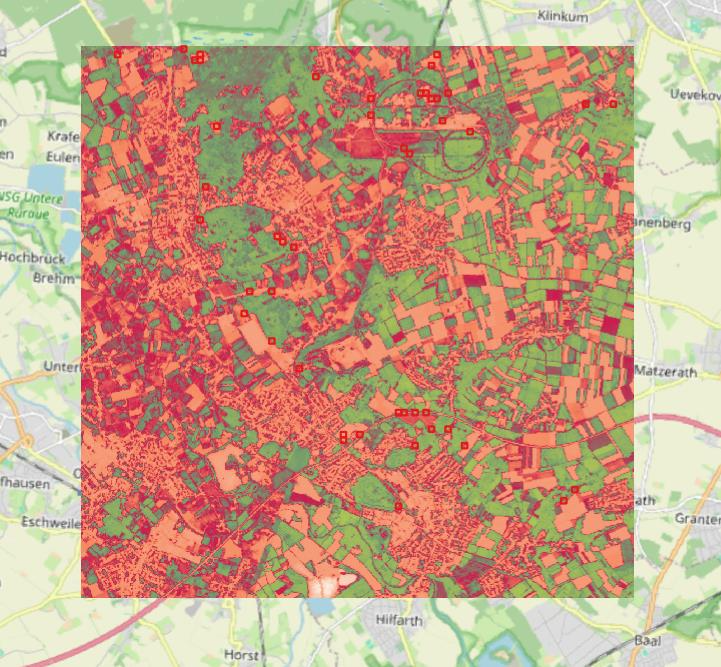